In [ ]:
### %load_ext autoreload
import glob
import nibabel 
from nilearn import plotting
import pandas as pd
import numpy as np
import h5py
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook, tqdm
from joblib import Parallel, delayed

from IPython.core.debugger import set_trace

import os
import shutil
import pickle

import torch
import torch.nn.functional as F

from utils import create_dicts, normalize, load, video, video_comparison

from multiprocessing import cpu_count
N_CPU = cpu_count()

from IPython.core.display import display, HTML
from celluloid import Camera

SEED = 42
%autoreload 2

# Affine transform

In [212]:
# orig_path = '../fcd_data/radiologist/fmriprep/sub-43/anat/sub-43_acq-T1MprageSagP2Iso_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5'

In [237]:
orig_path = '../fcd_data/radiologist/fmriprep/sub-43/anat/sub-43_acq-T1MprageSagP2Iso_desc-preproc_T1w.nii.gz'
orig_mask_path = '../fcd_data/radiologist/fmriprep/sub-43/anat/sub-43_acq-T1MprageSagP2Iso_desc-brain_mask.nii.gz'

In [245]:
brain = nibabel.load(orig_path).get_fdata()
mask = nibabel.load(orig_mask_path).get_fdata()
brain_strip = brain*mask

In [246]:
brain.shape, mask.shape

((192, 352, 352), (192, 352, 352))

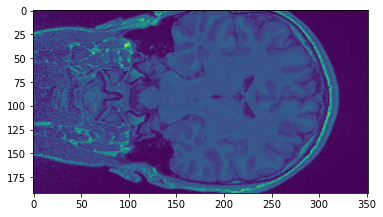

In [247]:
plt.imshow(brain[:,150,:])

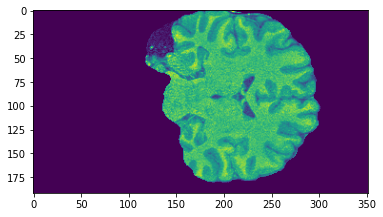

In [248]:
plt.imshow(brain_strip[:,150,:])

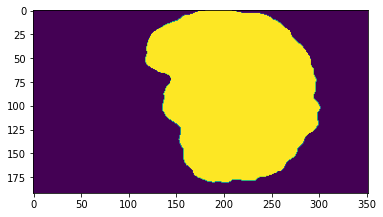

In [243]:
plt.imshow(mask[:,150,:])

In [213]:
dseg_orig_path = '../fcd_data/radiologist/fmriprep/sub-43/anat/sub-43_acq-T1MprageSagP2Iso_dseg.nii.gz'
trans_path = '../fcd_data/radiologist/fmriprep/sub-43/anat/sub-43_acq-T1MprageSagP2Iso_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

In [214]:
orig_path = '../fcd_data/radiologist/fmriprep/sub-43/anat/sub-43_acq-T1MprageSagP2Iso_desc-preproc_T1w.nii.gz'
trans_path = '../fcd_data/radiologist/fmriprep/sub-43/anat/sub-43_acq-T1MprageSagP2Iso_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

In [216]:
dseg_orig = nibabel.load(dseg_orig_path)
X_dseg_orig = dseg_orig.get_fdata()

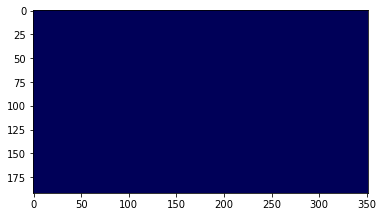

In [217]:
plt.ioff()
camera = video(X_orig, 
               X_dseg_orig,
              n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

T1MprageSagP2Iso_space-MNI152NLin2009cAsym

In [218]:
X_orig.shape, X_dseg_orig.shape

((192, 352, 352), (192, 352, 352))

In [219]:
data_orig = nibabel.load(orig_path)
data_trans = nibabel.load(trans_path)

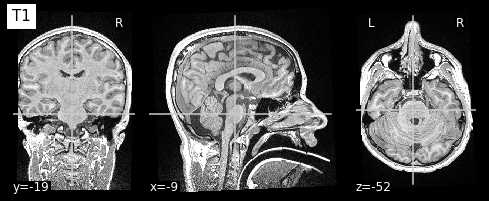

In [220]:
plotting.plot_anat(orig_path, title="T1", vmax=500)

In [221]:
X_orig = data_orig.get_fdata()
X_trans = data_trans.get_fdata()

In [222]:
X,Y,Z = X_orig.shape

In [223]:
grid = np.stack(np.meshgrid(np.arange(X), np.arange(Y), np.arange(Z), indexing='ij'), 0)
grid = np.concatenate([grid, np.ones((1,X,Y,Z))]).astype(int).reshape((4,-1))

In [224]:
# data_trans_affine = nibabel.Nifti1Image(X_orig, affine=data_orig.affine)
# X_trans_affine = data_trans_affine.get_fdata()
# np.all(X_trans_affine == X_orig)

In [225]:
X_trans_affine = np.zeros_like(X_trans)

grid_trans = (data_orig.affine @ grid)[:3,:] #.reshape(grid.shape)
grid_trans = (np.array(X_trans.shape)[:,None] - 1) * ((grid_trans - grid_trans.min(1)[:,None])/(grid_trans.max(1)[:,None] - grid_trans.min(1)[:,None]))

In [226]:
grid_trans = grid_trans.astype(int)

In [227]:
X_trans_affine[grid_trans[0], grid_trans[1], grid_trans[2]] = X_orig[grid[0], grid[1], grid[2]]

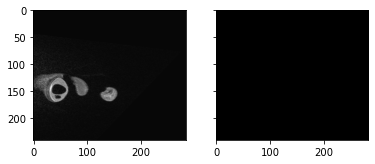

In [228]:
plt.ioff()
camera = video_comparison([X_trans, X_trans_affine],
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [198]:
X_trans.shape, X_trans_affine.shape

((241, 336, 283), (241, 336, 283))

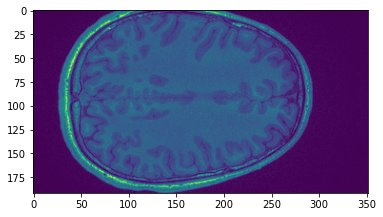

In [45]:
plt.figure()
plt.imshow(X_orig[:,:,240])
plt.show()

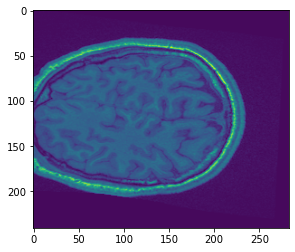

In [35]:
plt.figure()
plt.imshow(X_trans[:,80,:])
plt.show()

ants reading data.affine and apply it? - add svd decomposition?

In [3]:
matrix = h5py.File(affine_pth, "r")

In [7]:
matrix.keys()

<KeysViewHDF5 ['HDFVersion', 'ITKVersion', 'OSName', 'OSVersion', 'TransformGroup']>

In [8]:
for k,v in matrix.items():
    print(k,v)

HDFVersion <HDF5 dataset "HDFVersion": shape (1,), type "|O">
ITKVersion <HDF5 dataset "ITKVersion": shape (1,), type "|O">
OSName <HDF5 dataset "OSName": shape (1,), type "|O">
OSVersion <HDF5 dataset "OSVersion": shape (1,), type "|O">
TransformGroup <HDF5 group "/TransformGroup" (3 members)>


In [9]:
matrix_tg = matrix['TransformGroup']

In [10]:
for k,v in matrix_tg.items():
    print('----------------')
    print(k,v, 'has:...')
    
    for k_,v_ in v.items():
        print(k_,v_)

----------------
0 <HDF5 group "/TransformGroup/0" (1 members)> has:...
TransformType <HDF5 dataset "TransformType": shape (1,), type "|O">
----------------
1 <HDF5 group "/TransformGroup/1" (3 members)> has:...
TransformFixedParameters <HDF5 dataset "TransformFixedParameters": shape (3,), type "<f8">
TransformParameters <HDF5 dataset "TransformParameters": shape (12,), type "<f4">
TransformType <HDF5 dataset "TransformType": shape (1,), type "|O">
----------------
2 <HDF5 group "/TransformGroup/2" (3 members)> has:...
TransformFixedParameters <HDF5 dataset "TransformFixedParameters": shape (18,), type "<f8">
TransformParameters <HDF5 dataset "TransformParameters": shape (25590063,), type "<f4">
TransformType <HDF5 dataset "TransformType": shape (1,), type "|O">


take a look at shape 12 - 3x4

In [6]:
matrix.create_dataset()

<HDF5 file "sub-43_acq-T1MprageSagP2Iso_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5" (mode r)>

In [6]:
brain_path_orig = '/nfs/garfield/ibulygin/preprocessed_data_v2/fmriprep/sub-n8/anat/'
brain_path_mn152 = '/nfs/garfield/ibulygin/preprocessed_data_v2/fmriprep/sub-n10/anat/sub-n10_acq-T1MprageSagP2IsoOrig_desc-preproc_T1w.nii.gz'

brain_sample = nibabel.load(brain_path).get_fdata()

In [ ]:
ls -la 

In [4]:
brain_sample.shape

(192, 352, 352)